In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

In [2]:
# If file is in the same directory:
df = pd.read_csv("/content/finalheart.csv")

# Quick peek
print("Shape:", df.shape)
df.head()


Shape: (1300000, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,59,1,1,157,252,0,0,162,0,1.606718,1,0,2,0
1,53,1,0,137,220,0,1,169,1,0.515428,1,0,1,1
2,61,1,1,128,234,1,1,179,1,1.291485,2,2,1,1
3,70,1,3,121,254,0,0,122,0,2.165890,0,0,1,1
4,52,1,0,142,184,0,1,159,0,1.333539,2,0,3,1


In [3]:
print("Shape:", df.shape)

print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

print("\nTarget distribution (counts):")
print(df['target'].value_counts())

print("\nTarget distribution (proportions):")
print(df['target'].value_counts(normalize=True))

Shape: (1300000, 14)

Data types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Duplicate rows: 0

Target distribution (counts):
target
1    859413
0    440587
Name: count, dtype: int64

Target distribution (proportions):
target
1    0.661087
0    0.338913
Name: proportion, dtype: float64


In [6]:

df = df.drop_duplicates()


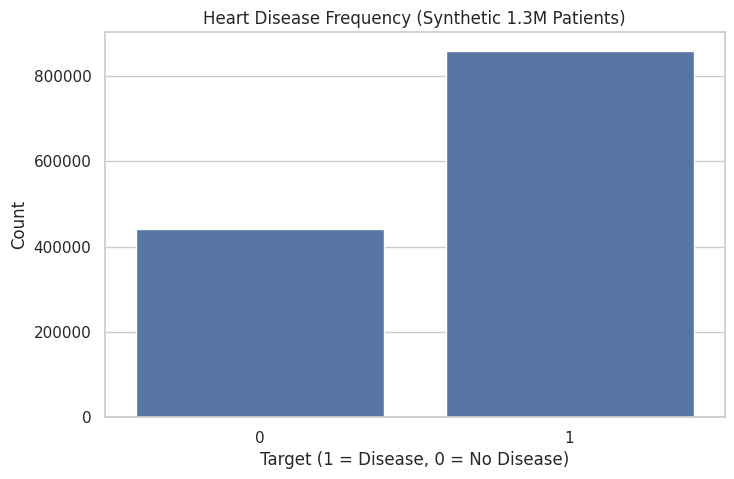

In [7]:

sns.countplot(x='target', data=df)
plt.title("Heart Disease Frequency (Synthetic 1.3M Patients)")
plt.xlabel("Target (1 = Disease, 0 = No Disease)")
plt.ylabel("Count")
plt.show()

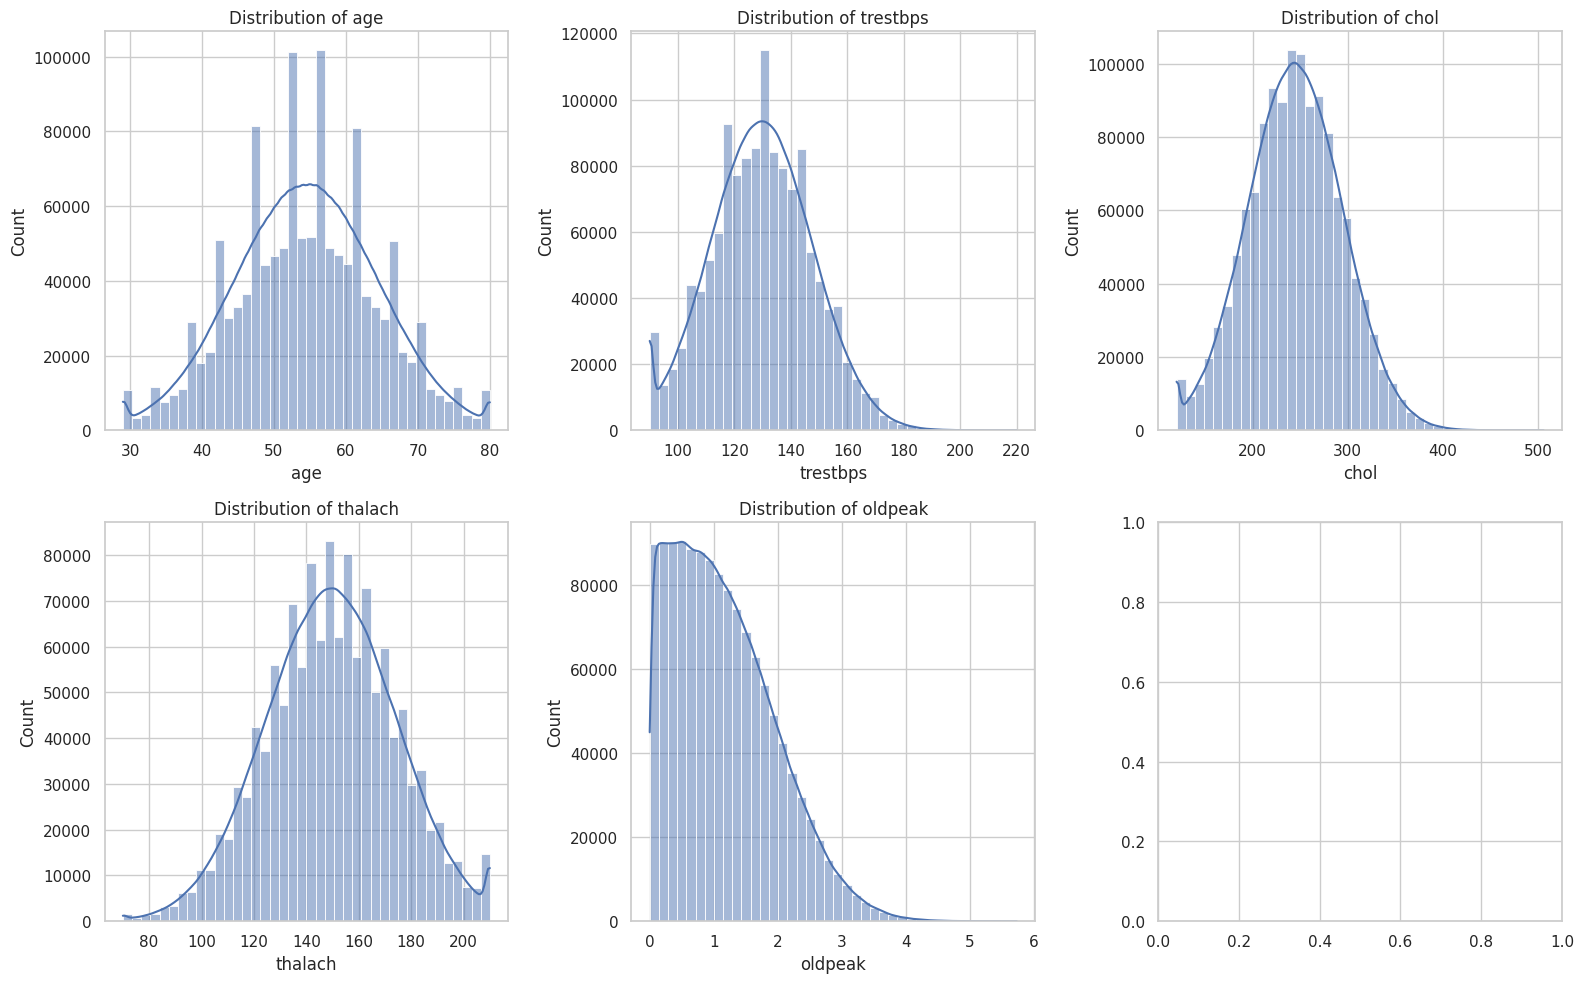

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

num_cols = ['age','trestbps','chol','thalach','oldpeak']
for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=40, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


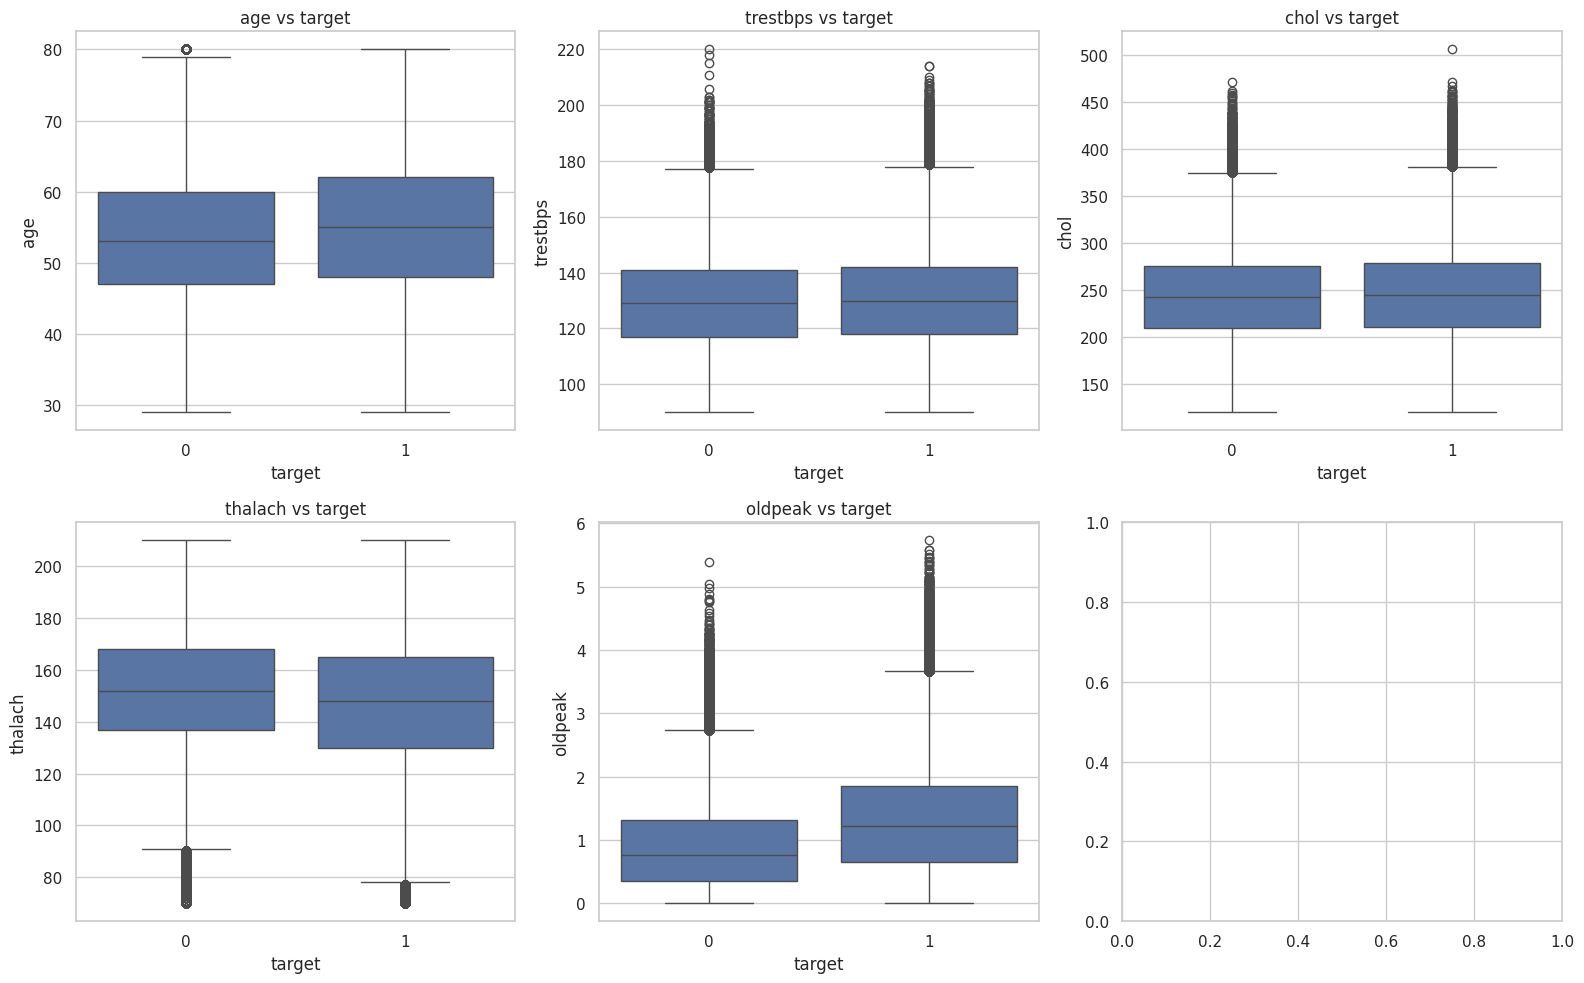

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.boxplot(x='target', y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs target")

plt.tight_layout()
plt.show()

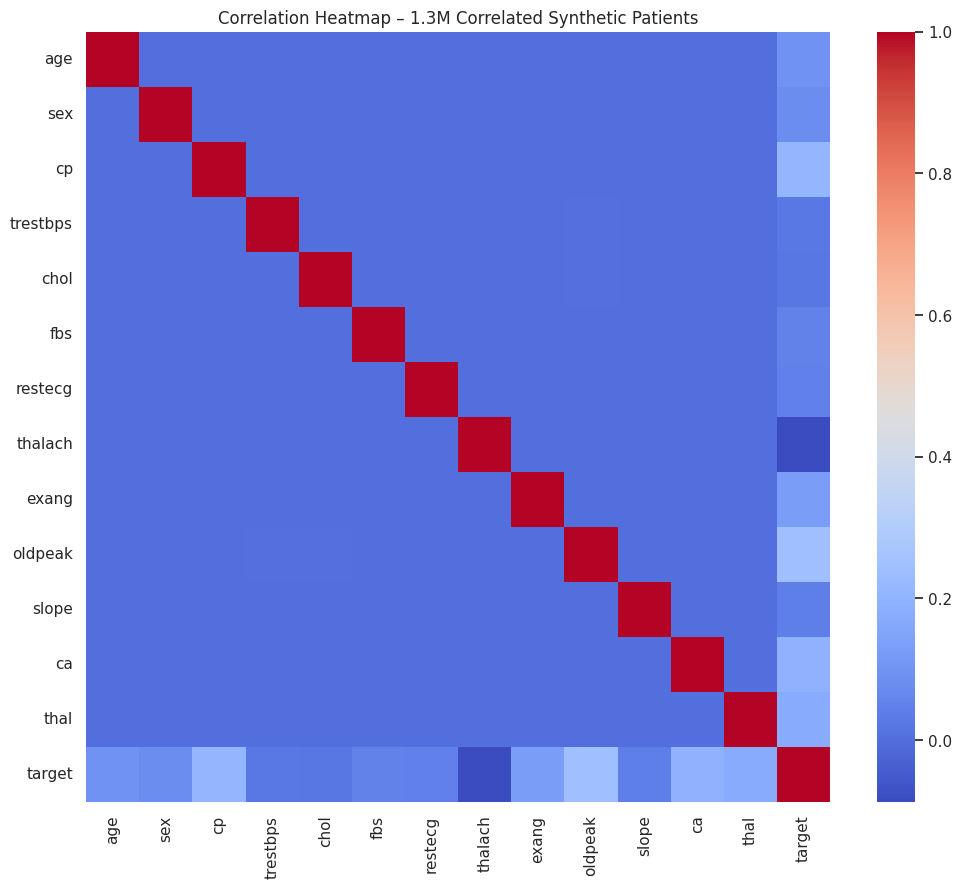

Correlation with target:

target      1.000000
oldpeak     0.242126
cp          0.208049
ca          0.193759
thal        0.168380
exang       0.126359
age         0.092629
sex         0.081270
fbs         0.050007
restecg     0.047563
slope       0.041165
trestbps    0.025647
chol        0.019060
thalach    -0.087172
Name: target, dtype: float64


In [11]:
# Full correlation matrix (numeric only)
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap – 1.3M Correlated Synthetic Patients")
plt.show()

# Correlation of each feature with target, sorted
corr_target = corr['target'].sort_values(ascending=False)
print("Correlation with target:\n")
print(corr_target)

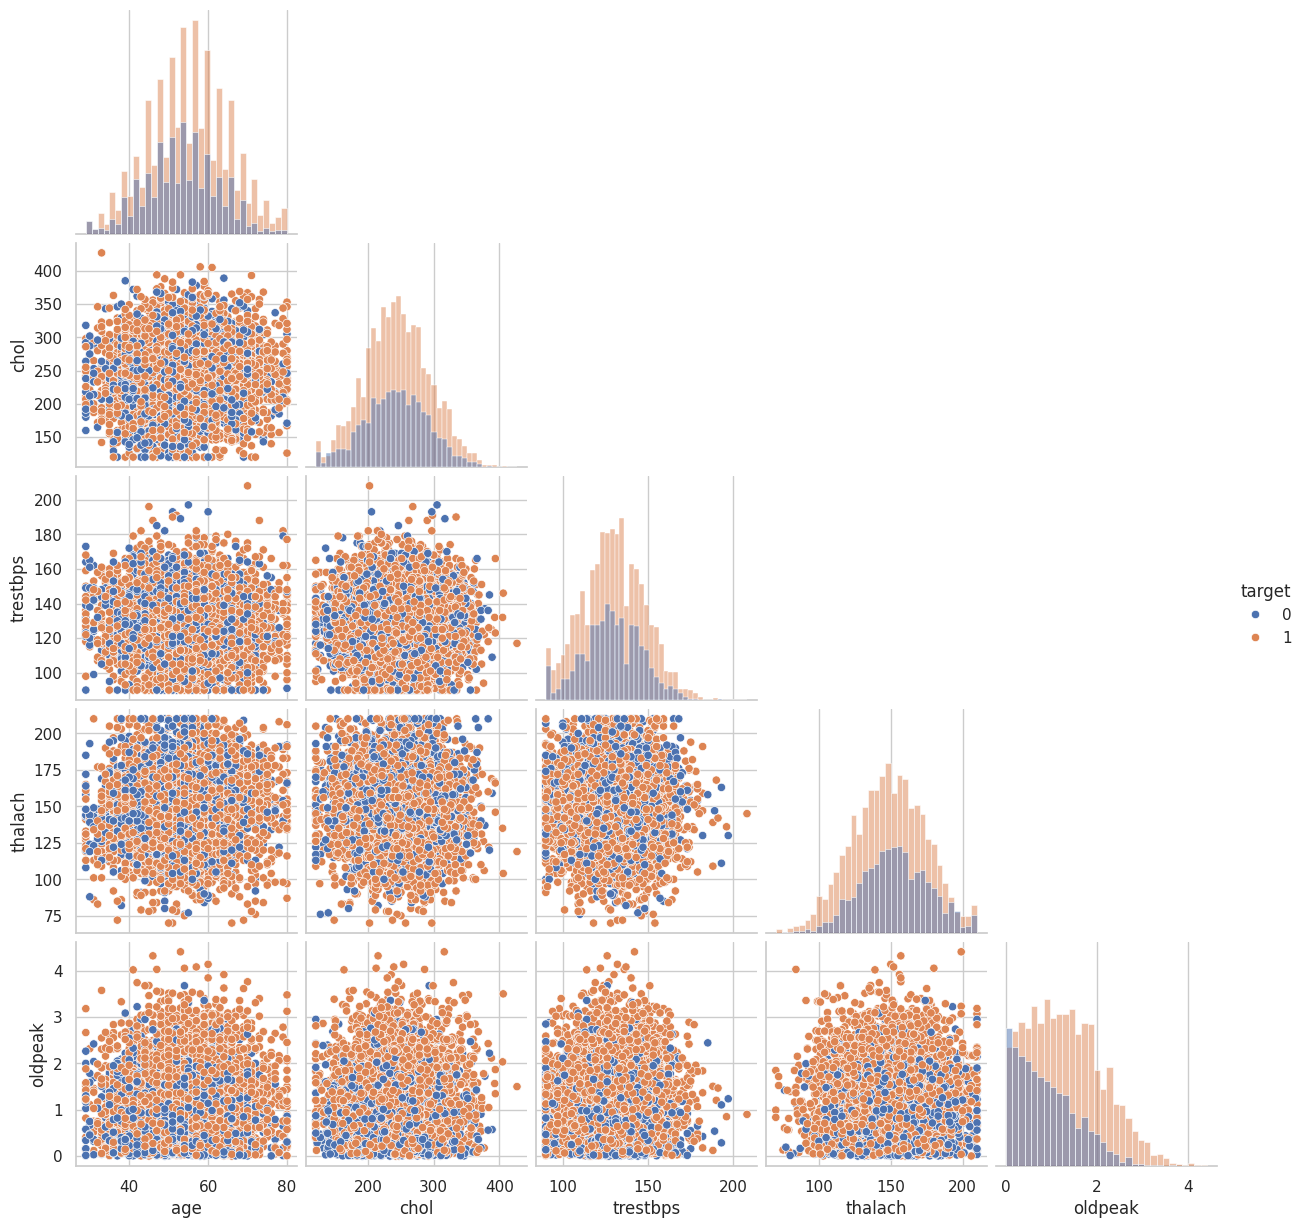

In [12]:
sample_df = df.sample(5000, random_state=42)

sns.pairplot(
    sample_df,
    vars=['age','chol','trestbps','thalach','oldpeak'],
    hue='target',
    diag_kind='hist',
    corner=True
)
plt.show()

In [13]:
num_cols = ['age','trestbps','chol','thalach','oldpeak']
cat_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

X = df.drop('target', axis=1)
y = df['target']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1040000, 13)
Test shape: (260000, 13)


In [15]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.7361115384615384
Precision: 0.7735044545907179
Recall   : 0.8496070001105404
F1 Score : 0.8097716239183536
ROC AUC  : 0.7784363396649595

Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.51      0.57     88117
           1       0.77      0.85      0.81    171883

    accuracy                           0.74    260000
   macro avg       0.71      0.68      0.69    260000
weighted avg       0.73      0.74      0.73    260000



In [17]:
def predict_heart_disease(input_data, model=rf_model):
    """
    input_data: tuple/list with 13 values in this exact order:

    [age, sex, cp, trestbps, chol, fbs, restecg,
     thalach, exang, oldpeak, slope, ca, thal]
    """
    columns = ['age','sex','cp','trestbps','chol','fbs','restecg',
               'thalach','exang','oldpeak','slope','ca','thal']

    df_input = pd.DataFrame([input_data], columns=columns)

    prediction = model.predict(df_input)[0]
    probability = model.predict_proba(df_input)[0][1]

    if prediction == 1:
        return f"🔴 High chance of Heart Disease (Probability: {probability:.2f})"
    else:
        return f"🟢 No Heart Disease Likely (Probability: {probability:.2f})"


In [18]:
test_patient = (50, 1, 2, 130, 250, 0, 1, 150, 0, 1.0, 1, 0, 2)
print(predict_heart_disease(test_patient))


🟢 No Heart Disease Likely (Probability: 0.41)


In [21]:
sample1 = (45, 1, 0, 120, 225, 0, 0, 165, 0, 0.5, 1, 0, 2)   # Low-risk
sample2 = (38, 0, 1, 110, 180, 0, 1, 170, 0, 0.0, 1, 0, 2)   # Healthy female
sample3 = (60, 1, 0, 130, 220, 0, 0, 150, 0, 1.0, 1, 0, 2)   # Older but stable

sample4 = (52, 1, 2, 135, 260, 0, 1, 140, 0, 1.4, 1, 0, 3)   # Moderate risk
sample5 = (58, 0, 1, 150, 245, 0, 0, 155, 0, 1.2, 1, 1, 2)   # Moderate risk
sample6 = (49, 1, 2, 125, 210, 0, 1, 160, 0, 2.0, 2, 0, 2)   # Moderate ST depression

sample7 = (63, 1, 3, 145, 300, 1, 2, 120, 1, 3.5, 2, 2, 3)   # High risk
sample8 = (57, 1, 2, 140, 280, 0, 1, 130, 1, 4.0, 2, 2, 3)   # High ST depression
sample9 = (70, 1, 3, 160, 300, 1, 2, 115, 1, 5.2, 2, 3, 3)   # Very high risk

sample10 = (66, 0, 3, 155, 320, 0, 2, 108, 1, 2.8, 2, 2, 3)  # Severe risk

sample11 = (54, 1, 1, 132, 246, 0, 1, 160, 0, 1.0, 1, 0, 2)  # Mixed profile
sample12 = (42, 0, 2, 120, 195, 0, 0, 168, 0, 0.2, 1, 0, 2)  # Younger, healthy
sample13 = (61, 1, 3, 152, 295, 1, 2, 130, 1, 3.4, 2, 1, 3)  # High risk
sample14 = (47, 1, 2, 128, 240, 0, 1, 158, 0, 1.6, 1, 0, 2)  # Mild risk
sample15 = (51, 0, 1, 118, 230, 0, 1, 165, 0, 0.8, 1, 0, 2)  # Healthy profile

samples = [
    sample1, sample2, sample3, sample4, sample5,
    sample6, sample7, sample8, sample9, sample10,
    sample11, sample12, sample13, sample14, sample15
]

for i, s in enumerate(samples, start=1):
    print(f"Sample {i}: {s}")
    print("Result:", predict_heart_disease(s))
    print("-" * 60)

Sample 1: (45, 1, 0, 120, 225, 0, 0, 165, 0, 0.5, 1, 0, 2)
Result: 🟢 No Heart Disease Likely (Probability: 0.23)
------------------------------------------------------------
Sample 2: (38, 0, 1, 110, 180, 0, 1, 170, 0, 0.0, 1, 0, 2)
Result: 🟢 No Heart Disease Likely (Probability: 0.39)
------------------------------------------------------------
Sample 3: (60, 1, 0, 130, 220, 0, 0, 150, 0, 1.0, 1, 0, 2)
Result: 🟢 No Heart Disease Likely (Probability: 0.36)
------------------------------------------------------------
Sample 4: (52, 1, 2, 135, 260, 0, 1, 140, 0, 1.4, 1, 0, 3)
Result: 🔴 High chance of Heart Disease (Probability: 0.92)
------------------------------------------------------------
Sample 5: (58, 0, 1, 150, 245, 0, 0, 155, 0, 1.2, 1, 1, 2)
Result: 🔴 High chance of Heart Disease (Probability: 0.77)
------------------------------------------------------------
Sample 6: (49, 1, 2, 125, 210, 0, 1, 160, 0, 2.0, 2, 0, 2)
Result: 🔴 High chance of Heart Disease (Probability: 0.89)
--